# Offline Testing

### 0. Imports

In [106]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML
import csv

# 1. Set up the notebook

Define a function to display Mediaspace videos.

In [124]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [107]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to compute RMSE.

In [108]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define a function to compare state estimates from default and custom observers.

In [109]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (old custom observer)', linewidth=2)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=3)
    ax.plot(t, s_offline, '--', label=f'{name} (new custom observer - offline)', linewidth=3)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

Define the rotation matrix $R_1^0$ as a function of the yaw angle $\psi$, the pitch angle $\theta$, and the roll angle $\phi$.

In [110]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_1in0 that describes the orientation of the drone
# (i.e., of frame 1 in the coordinates of frame 0)
R_1in0 = Rz @ Ry @ Rx

# Create a function that returns R_1in0 as a numpy array
R_1in0 = sym.lambdify((psi, theta, phi), R_1in0)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

# 2. Flight Tests to Debug Observer Implementation

## 2.1 Hover test using the old observer code

In [125]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_v4kurmd0')

Load and parse data.

In [112]:
# flight test data
data = load_hardware_data('flight-test-data\cc_co_hover_old_2.json', only_in_flight=False)

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Convert linear velocity estimates to the world frame.

In [113]:
# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], psi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

Apply offline implementation of custom observer.

In [115]:
# Define constants
g = 9.81
k_flow = 4.09255568
o_x_eq = 0.
o_y_eq = 0.
o_z_eq = 0.5
anchors_x = [-1.82, -3.57, 1.82, 2.67, -3.61, 1.84, 2.74, -1.85]
anchors_y = [2.18, 3.18, 2.21, -3.30, -3.30, -0.90, 3.18, -0.93]
anchors_z = [1.10, 2.24, 1.10, 2.20, 2.25, 1.10, 2.24, 1.09]
x0 = anchors_x[0]
x1 = anchors_x[1]
x2 = anchors_x[2]
x3 = anchors_x[3]
x4 = anchors_x[4]
x5 = anchors_x[5]
x6 = anchors_x[6]
x7 = anchors_x[7]
y0 = anchors_y[0]
y1 = anchors_y[1]
y2 = anchors_y[2]
y3 = anchors_y[3]
y4 = anchors_y[4]
y5 = anchors_y[5]
y6 = anchors_y[6]
y7 = anchors_y[7]
z0 = anchors_z[0]
z1 = anchors_z[1]
z2 = anchors_z[2]
z3 = anchors_z[3]
z4 = anchors_z[4]
z5 = anchors_z[5]
z6 = anchors_z[6]
z7 = anchors_z[7]
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
n_x_offline = data['ae483log.n_x']
n_y_offline = data['ae483log.n_y']
r_offline = data['ae483log.r']
d0_offline = data['ae483log.d0']
d1_offline = data['ae483log.d1']
d2_offline = data['ae483log.d2']
d3_offline = data['ae483log.d3']
d4_offline = data['ae483log.d4']
d5_offline = data['ae483log.d5']
d6_offline = data['ae483log.d6']
d7_offline = data['ae483log.d7']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d0 = d0_offline[i]
    d1 = d1_offline[i]
    d2 = d2_offline[i]
    d3 = d3_offline[i]
    d4 = d4_offline[i]
    d5 = d5_offline[i]
    d6 = d6_offline[i]
    d7 = d7_offline[i]
    

    # Compute each element of:
    #
    #  C x + D u - y
    #
    Y_0 = (o_x*(o_x_eq - x0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_y*(o_y_eq - y0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_z*(o_z_eq - z0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) - d0 + np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq -  y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0))
    Y_1 = (o_x*(o_x_eq - x1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_y*(o_y_eq - y1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_z*(o_z_eq - z1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) - d1 + np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq -  y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1))
    Y_2 = (o_x*(o_x_eq - x2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_y*(o_y_eq - y2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_z*(o_z_eq - z2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) - d2 + np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq -  y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2))
    Y_3 = (o_x*(o_x_eq - x3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_y*(o_y_eq - y3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_z*(o_z_eq - z3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) - d3 + np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq -  y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3))
    Y_4 = (o_x*(o_x_eq - x4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_y*(o_y_eq - y4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_z*(o_z_eq - z4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) - d4 + np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq -  y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4))
    Y_5 = (o_x*(o_x_eq - x5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_y*(o_y_eq - y5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_z*(o_z_eq - z5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) - d5 + np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq -  y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5))
    Y_6 = (o_x*(o_x_eq - x6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_y*(o_y_eq - y6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_z*(o_z_eq - z6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) - d6 + np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq -  y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6))
    Y_7 = (o_x*(o_x_eq - x7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_y*(o_y_eq - y7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_z*(o_z_eq - z7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) - d7 + np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq -  y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7))
    Y_8 = -k_flow * w_y +(k_flow * v_x)/o_z_eq - n_x
    Y_9 = k_flow * w_x +(k_flow * v_y)/o_z_eq - n_y
    Y_10 = o_z - r
    
    # Update estimates
    o_x += dt*(-0.321942986156017*Y_0 - 0.360091197357167*Y_1 - 0.00693842240377889*Y_10 + 0.318365190026611*Y_2 + 0.299903852114275*Y_3 - 0.355665807343492*Y_4 + 0.442238005738499*Y_5 + 0.308597523816907*Y_6 - 0.440053855994591*Y_7 - 0.0715583737537656*Y_8 + 5.12544989507709e-5*Y_9 + v_x)
    o_y += dt*(0.421591401397973*Y_0 + 0.350885943671384*Y_1 + 0.0269048563831952*Y_10 + 0.423130343013224*Y_2 - 0.405422944003029*Y_3 - 0.355951808659831*Y_4 - 0.237318519656177*Y_5 + 0.391808269171014*Y_6 - 0.24175981326639*Y_7 + 5.17861682512524e-5*Y_8 - 0.0782767553493582*Y_9 + v_y)
    o_z += dt*(0.00978650662019886*Y_0 + 0.0166062866884265*Y_1 - 2.28018924263333*Y_10 + 0.00989397450977831*Y_2 + 0.0190825845349324*Y_3 + 0.0170945088575677*Y_4 + 0.0144196994197055*Y_5 + 0.0188045399251483*Y_6 + 0.0138106476337786*Y_7 - 1.11146555882439e-5*Y_8 + 4.07175659351284e-5*Y_9 + v_z)
    psi += dt * w_z
    theta += dt*(0.000743649050884714*Y_0 + 0.000832082214889116*Y_1 + 4.21524245183295e-6*Y_10 - 0.000737276508755911*Y_2 - 0.000692565690368467*Y_3 + 0.000823526337380634*Y_4 - 0.00102218290302062*Y_5 - 0.000714565289197534*Y_6 + 0.00101841351514599*Y_7 + 0.01645100613059*Y_8 - 1.21828073969702e-7*Y_9 + w_y)
    phi += dt*(0.0011102988440636*Y_0 + 0.000924017496367406*Y_1 + 1.32718313490127e-5*Y_10 + 0.00111634434284999*Y_2 - 0.00106702791703278*Y_3 - 0.000938737703011303*Y_4 - 0.00062368612223573*Y_5 + 0.00103399380969206*Y_6 - 0.000638144033820692*Y_7 + 1.3183332132583e-7*Y_8 - 0.0206557025088524*Y_9 + w_x)
    v_x += dt*(-0.0157809532951908*Y_0 - 0.0176554807788392*Y_1 - 0.000178319846793862*Y_10 + 0.0156333237437844*Y_2 + 0.0146982091913017*Y_3 - 0.0174629114240703*Y_4 + 0.021687439905286*Y_5 + 0.015152395274315*Y_6 - 0.0215988910728946*Y_7 - 0.269089559817413*Y_8 + 2.79600027359229e-6*Y_9 + g*theta)
    v_y += dt*(0.0217049934206139*Y_0 + 0.0180637216418776*Y_1 + 0.000686014553786233*Y_10 + 0.0218100340380711*Y_2 - 0.020864233505667*Y_3 - 0.0183430854593641*Y_4 - 0.0122013771782201*Y_5 + 0.0201990669214066*Y_6 - 0.0124657913716817*Y_7 + 2.93619610321487e-6*Y_8 - 0.29435501592153*Y_9 - g*phi)
    v_z += dt*(0.0112727231781869*Y_0 + 0.0189425160283223*Y_1 - 2.57345089101819*Y_10 + 0.0113181546686818*Y_2 + 0.0213193506325072*Y_3 + 0.0191761230779908*Y_4 + 0.0161150786052919*Y_5 + 0.0213619095276965*Y_6 + 0.0155311781876625*Y_7 - 1.41496323216679e-5*Y_8 + 5.26120758410498e-5*Y_9 + a_z - g)

    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

d0_calc = np.sqrt((o_x_offline - anchors_x[0]) ** 2 + (o_y_offline - anchors_y[0]) ** 2 + (o_z_offline - anchors_z[0]) ** 2)
d1_calc = np.sqrt((o_x_offline - anchors_x[1]) ** 2 + (o_y_offline - anchors_y[1]) ** 2 + (o_z_offline - anchors_z[1]) ** 2)
d2_calc = np.sqrt((o_x_offline - anchors_x[2]) ** 2 + (o_y_offline - anchors_y[2]) ** 2 + (o_z_offline - anchors_z[2]) ** 2)
d3_calc = np.sqrt((o_x_offline - anchors_x[3]) ** 2 + (o_y_offline - anchors_y[3]) ** 2 + (o_z_offline - anchors_z[3]) ** 2)
d4_calc = np.sqrt((o_x_offline - anchors_x[4]) ** 2 + (o_y_offline - anchors_y[4]) ** 2 + (o_z_offline - anchors_z[4]) ** 2)
d5_calc = np.sqrt((o_x_offline - anchors_x[5]) ** 2 + (o_y_offline - anchors_y[5]) ** 2 + (o_z_offline - anchors_z[5]) ** 2)
d6_calc = np.sqrt((o_x_offline - anchors_x[6]) ** 2 + (o_y_offline - anchors_y[6]) ** 2 + (o_z_offline - anchors_z[6]) ** 2)
d7_calc = np.sqrt((o_x_offline - anchors_x[7]) ** 2 + (o_y_offline - anchors_y[7]) ** 2 + (o_z_offline - anchors_z[7]) ** 2)

Calculate RMSE values for the state variables and node distances.

In [116]:
o_x_rmse = np.zeros(1000)
o_y_rmse = np.zeros(1000)
o_z_rmse = np.zeros(1000)
psi_rmse = np.zeros(1000)
theta_rmse = np.zeros(1000)
phi_rmse = np.zeros(1000)
v_x_rmse = np.zeros(1000)
v_y_rmse = np.zeros(1000)
v_z_rmse = np.zeros(1000)
d_0_rmse = np.zeros(1000)
d_1_rmse = np.zeros(1000)
d_2_rmse = np.zeros(1000)
d_3_rmse = np.zeros(1000)
d_4_rmse = np.zeros(1000)
d_5_rmse = np.zeros(1000)
d_6_rmse = np.zeros(1000)
d_7_rmse = np.zeros(1000)

for i in range(1000):
    o_x_rmse[i] = rmse(o_x_custom[i], o_x_offline[i])
    o_y_rmse[i] = rmse(o_y_custom[i], o_y_offline[i])
    o_z_rmse[i] = rmse(o_z_custom[i], o_z_offline[i])
    psi_rmse[i] = rmse(psi_custom[i], psi_offline[i])
    theta_rmse[i] = rmse(theta_custom[i], theta_offline[i])
    phi_rmse[i] = rmse(phi_custom[i], phi_offline[i])
    v_x_rmse[i] = rmse(v_x_custom[i], v_x_offline[i])
    v_y_rmse[i] = rmse(v_y_custom[i], v_y_offline[i])
    v_z_rmse[i] = rmse(v_z_custom[i], v_z_offline[i])
    d_0_rmse[i] = rmse(d0_calc[i], d0_offline[i])
    d_1_rmse[i] = rmse(d1_calc[i], d1_offline[i])
    d_2_rmse[i] = rmse(d2_calc[i], d2_offline[i])
    d_3_rmse[i] = rmse(d3_calc[i], d3_offline[i])
    d_4_rmse[i] = rmse(d4_calc[i], d4_offline[i])
    d_5_rmse[i] = rmse(d5_calc[i], d5_offline[i])
    d_6_rmse[i] = rmse(d6_calc[i], d6_offline[i])
    d_7_rmse[i] = rmse(d7_calc[i], d7_offline[i])

print('RMSE Values:')
print('States')
print('o_x:     ' + str(round(o_x_rmse.mean(), 3)))
print('o_y:     ' + str(round(o_y_rmse.mean(), 3)))
print('o_z:     ' + str(round(o_z_rmse.mean(), 3)))
print('psi:     ' + str(round(psi_rmse.mean(), 3)))
print('theta:   ' + str(round(theta_rmse.mean(), 3)))
print('phi:     ' + str(round(phi_rmse.mean(), 3)))
print('v_x:     ' + str(round(v_x_rmse.mean(), 3)))
print('v_y:     ' + str(round(v_y_rmse.mean(), 3)))
print('v_z:     ' + str(round(v_z_rmse.mean(), 3)))
print('Distances')
print('d_0:     ' + str(round(d_0_rmse.mean(), 3)))
print('d_1:     ' + str(round(d_1_rmse.mean(), 3)))
print('d_2:     ' + str(round(d_2_rmse.mean(), 3)))
print('d_3:     ' + str(round(d_3_rmse.mean(), 3)))
print('d_4:     ' + str(round(d_4_rmse.mean(), 3)))
print('d_5:     ' + str(round(d_5_rmse.mean(), 3)))
print('d_6:     ' + str(round(d_6_rmse.mean(), 3)))
print('d_7:     ' + str(round(d_7_rmse.mean(), 3)))

RMSE Values:
States
o_x:     0.471
o_y:     0.511
o_z:     0.037
psi:     0.003
theta:   0.016
phi:     0.143
v_x:     0.052
v_y:     0.469
v_z:     0.051
Distances
d_0:     0.362
d_1:     0.218
d_2:     0.327
d_3:     0.309
d_4:     0.333
d_5:     0.066
d_6:     1.911
d_7:     0.892


Plot position values.

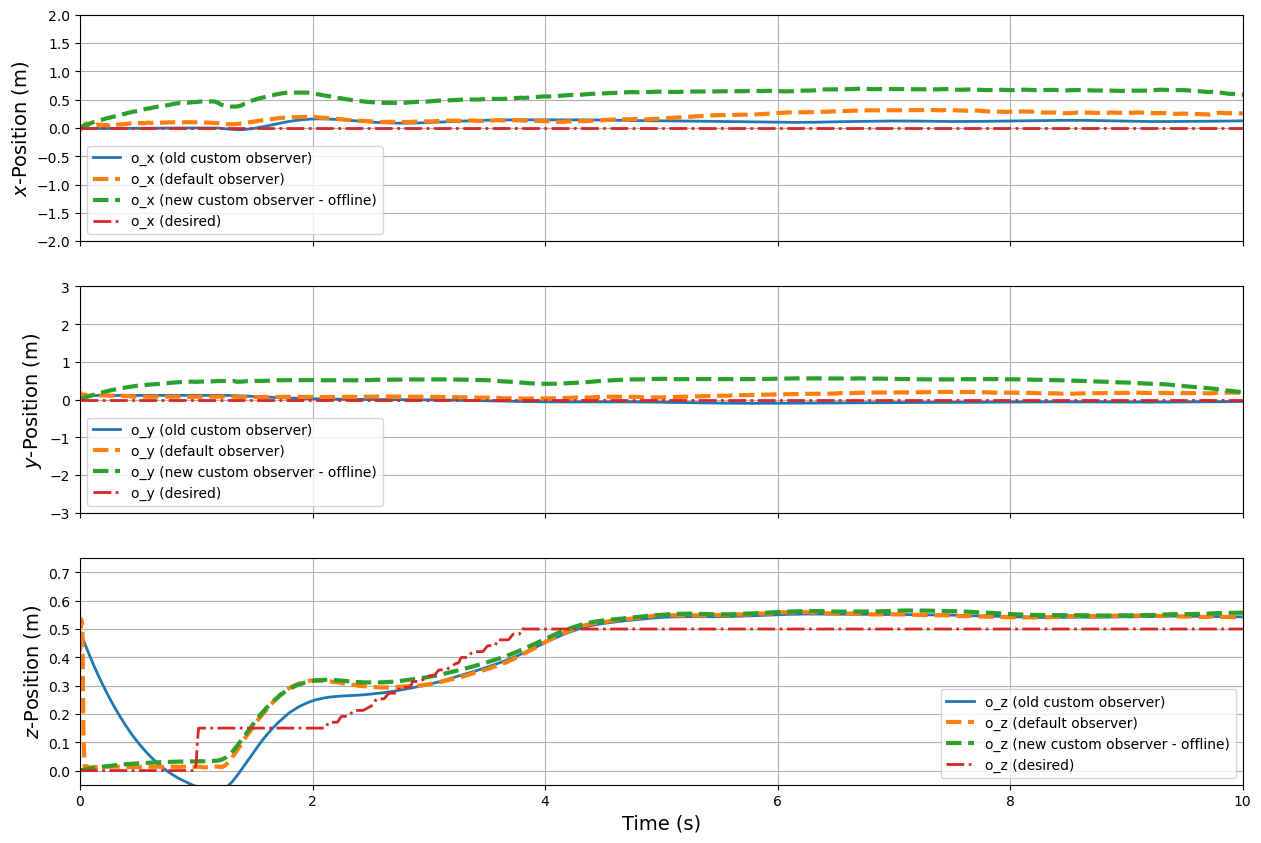

In [117]:
fig, (ax_o_x,
      ax_o_y,
      ax_o_z) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
ax_o_z.set_xlabel('Time (s)', fontsize=14)
ax_o_x.set_ylabel('$x$-Position (m)', fontsize=14)
ax_o_y.set_ylabel('$y$-Position (m)', fontsize=14)
ax_o_z.set_ylabel('$z$-Position (m)', fontsize=14)

ax_o_x.set_ylim([-2, 2])
ax_o_y.set_ylim([-3, 3])
ax_o_z.set_ylim([-0.05, 0.75])

ax_o_z.set_xlim([0, 10])
fig.savefig('graphs\pos_offline.png')

Plot orientation values.

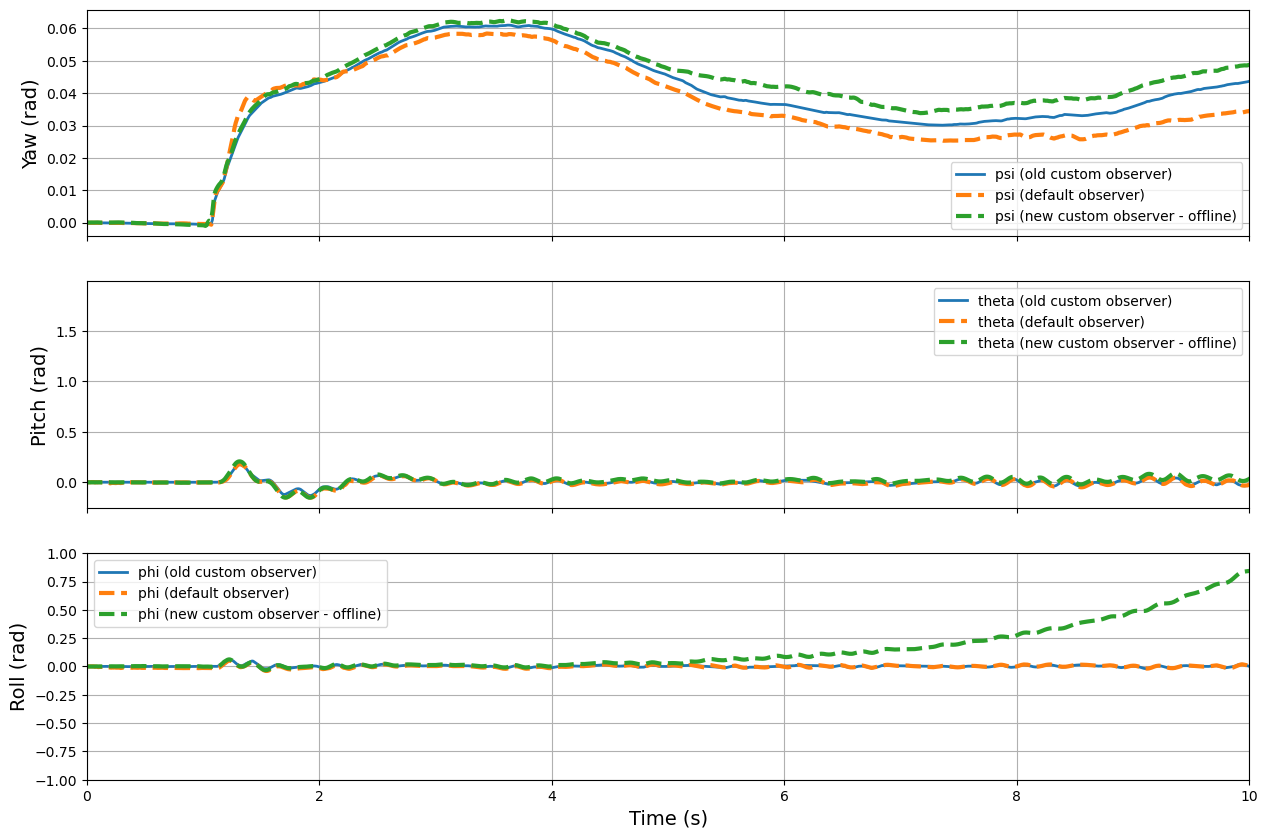

In [118]:
fig, (ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
ax_phi.set_xlabel('Time (s)', fontsize=14)
ax_psi.set_ylabel('Yaw (rad)', fontsize=14)
ax_theta.set_ylabel('Pitch (rad)', fontsize=14)
ax_phi.set_ylabel('Roll (rad)', fontsize=14)

# ax_psi.set_ylim([-0.1, 0.1])
# ax_theta.set_ylim([-0.25, 0.25])
ax_phi.set_ylim([-1, 1])

ax_phi.set_xlim([0, 10])
fig.savefig('graphs\ori_offline.png')

Plot velocity values.

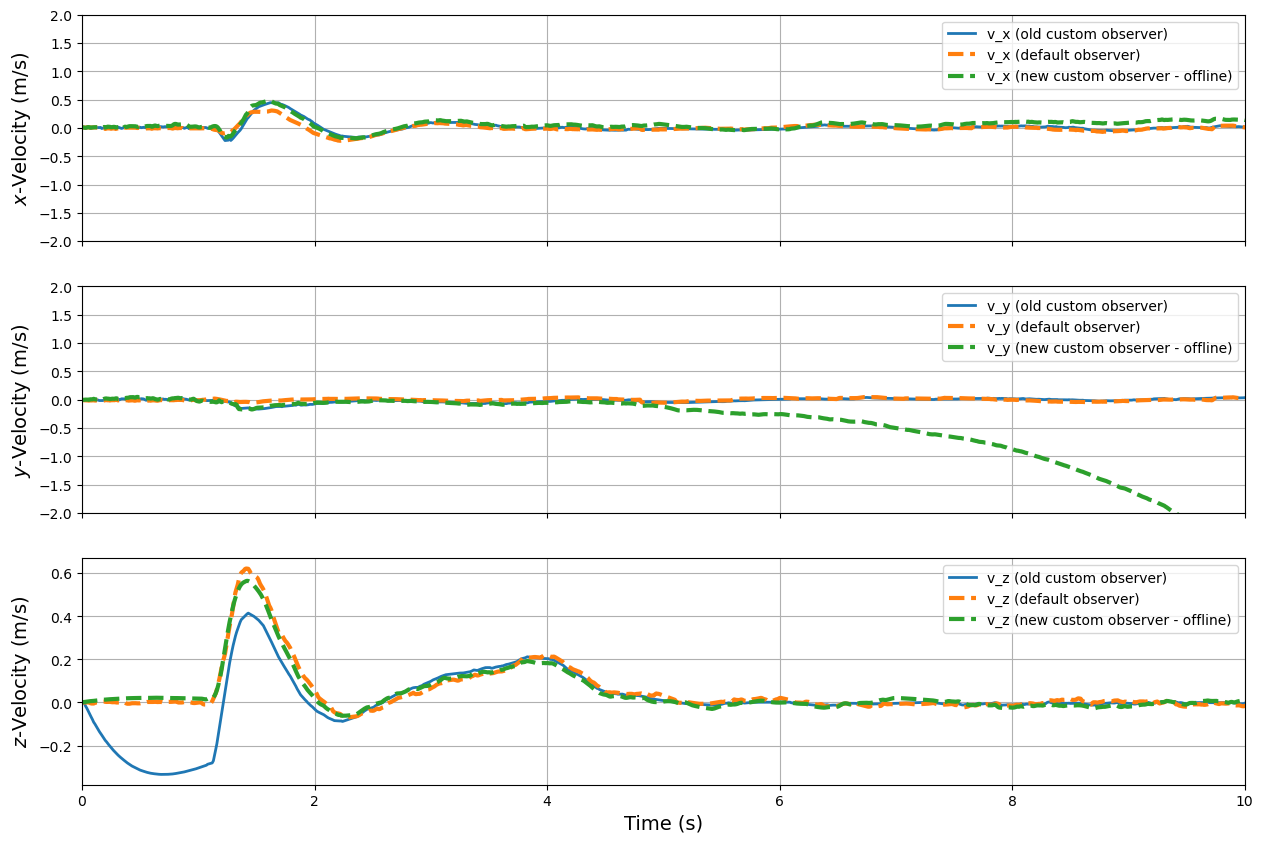

In [119]:
fig, (ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('Time (s)', fontsize=14)
ax_v_x.set_ylabel('$x$-Velocity (m/s)', fontsize=14)
ax_v_y.set_ylabel('$y$-Velocity (m/s)', fontsize=14)
ax_v_z.set_ylabel('$z$-Velocity (m/s)', fontsize=14)

ax_v_x.set_ylim([-2, 2])
ax_v_y.set_ylim([-2, 2])
# ax_v_z.set_ylim([-0.5, 0.5])

ax_v_z.set_xlim([0, 10])
fig.savefig('graphs\\vel_offline.png')

Plot loco node distance values

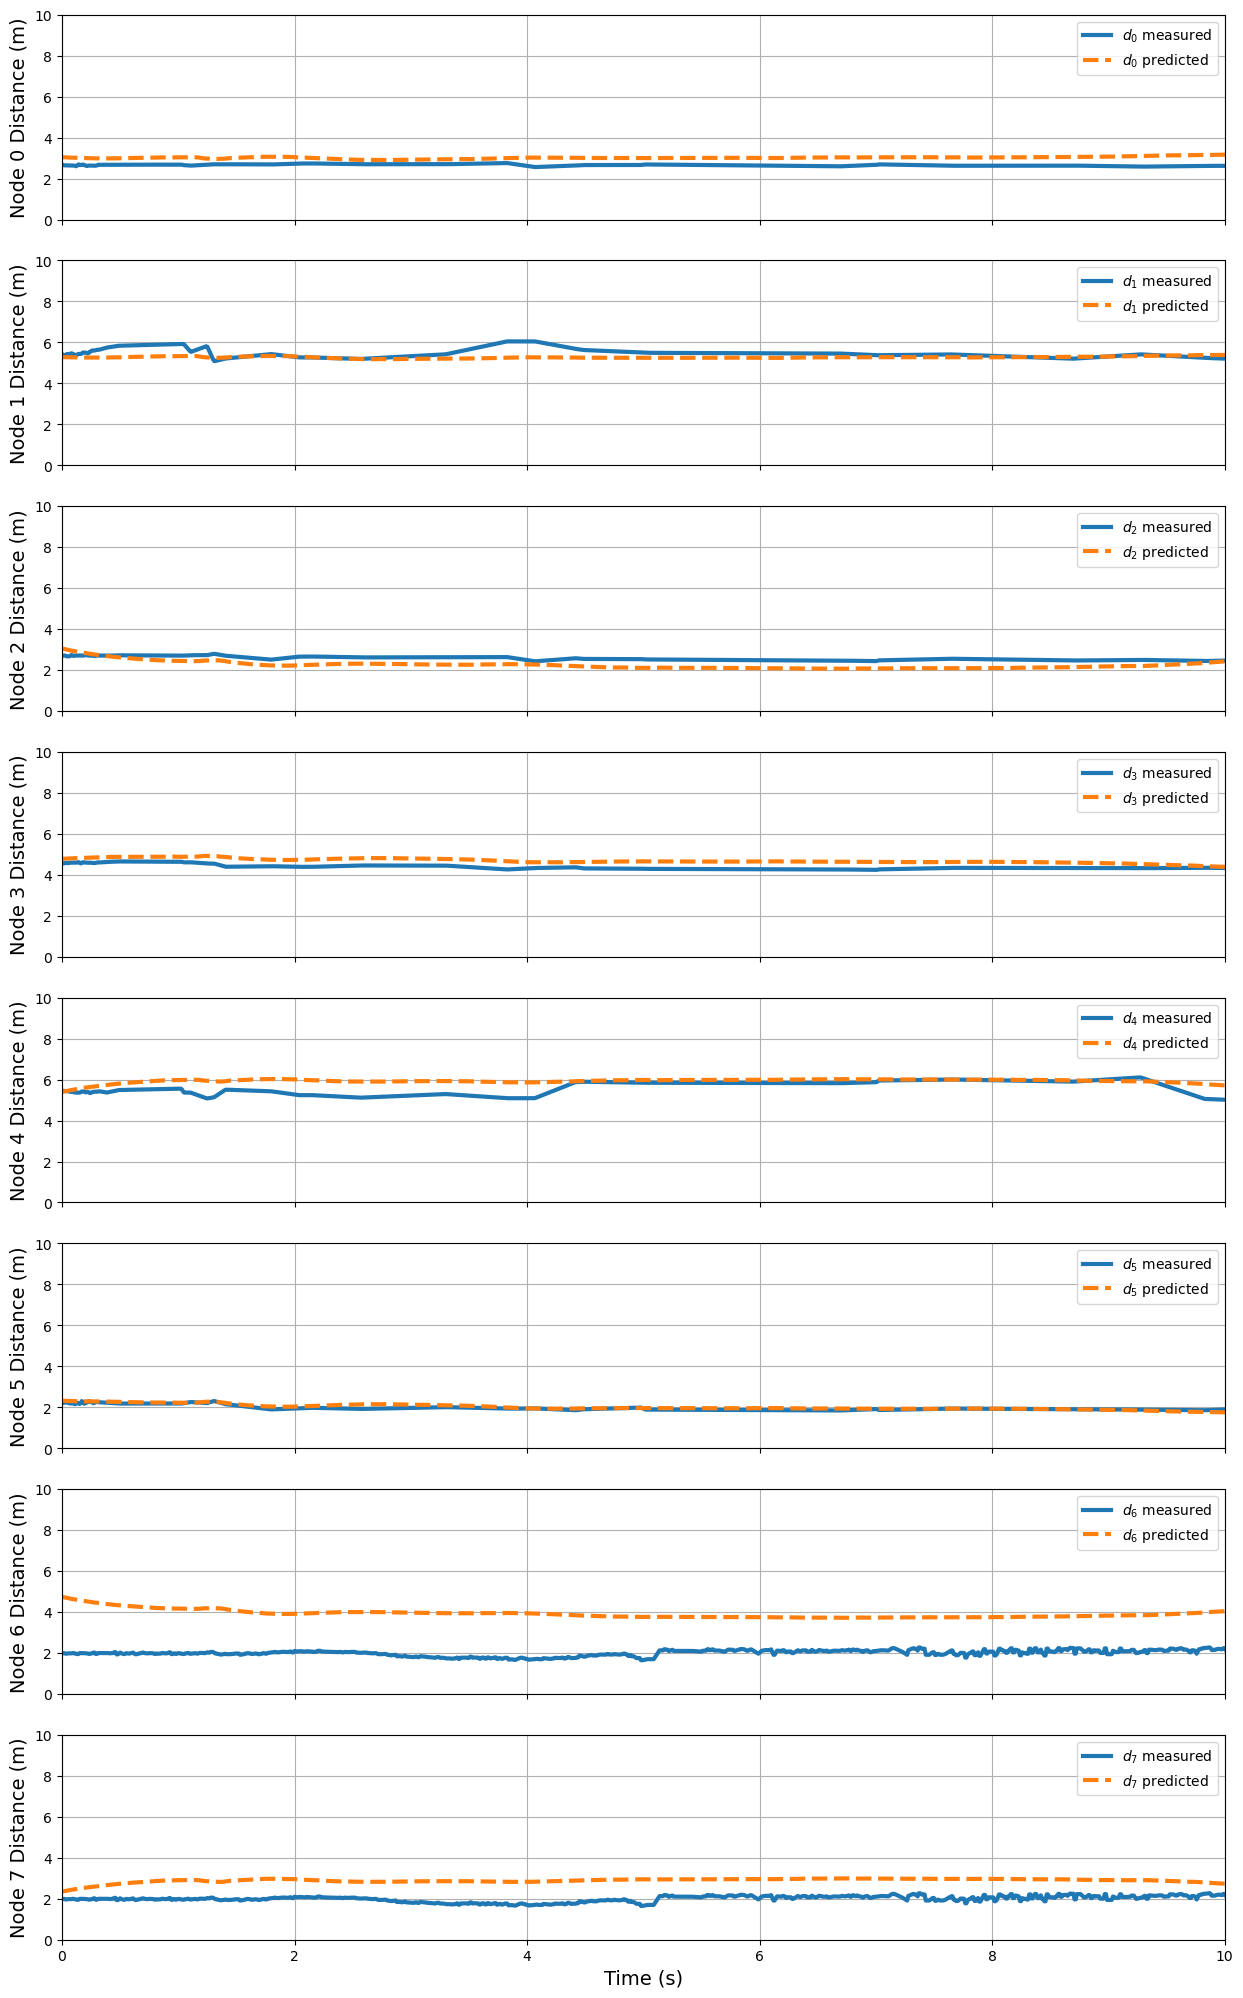

In [120]:
fig, (ax_d0,
      ax_d1,
      ax_d2,
      ax_d3,
      ax_d4,
      ax_d5,
      ax_d6,
      ax_d7) = plt.subplots(8, 1, figsize=(15, 25), sharex=True)

ax_d0.plot(t, d0_offline, '-', label='$d_0$ measured', linewidth=3)
ax_d0.plot(t, d0_calc, '--', label='$d_0$ predicted', linewidth=3)
ax_d0.set_ylabel('Node 0 Distance (m)', fontsize=14)
# ax_d0.set_xlim([0,10])
ax_d0.set_ylim([0, 10])
ax_d0.legend()
ax_d0.grid()

ax_d1.plot(t, d1_offline, '-', label='$d_1$ measured', linewidth=3)
ax_d1.plot(t, d1_calc, '--', label='$d_1$ predicted', linewidth=3)
ax_d1.set_ylabel('Node 1 Distance (m)', fontsize=14)
# ax_d1.set_xlim([0,10])
ax_d1.set_ylim([0, 10])
ax_d1.legend()
ax_d1.grid()

ax_d2.plot(t, d2_offline, '-', label='$d_2$ measured', linewidth=3)
ax_d2.plot(t, d2_calc, '--', label='$d_2$ predicted', linewidth=3)
ax_d2.set_ylabel('Node 2 Distance (m)', fontsize=14)
# ax_d2.set_xlim([0,10])
ax_d2.set_ylim([0, 10])
ax_d2.legend()
ax_d2.grid()

ax_d3.plot(t, d3_offline, '-', label='$d_3$ measured', linewidth=3)
ax_d3.plot(t, d3_calc, '--', label='$d_3$ predicted', linewidth=3)
ax_d3.set_ylabel('Node 3 Distance (m)', fontsize=14)
# ax_d3.set_xlim([0,10])
ax_d3.set_ylim([0, 10])
ax_d3.legend()
ax_d3.grid()

ax_d4.plot(t, d4_offline, '-', label='$d_4$ measured', linewidth=3)
ax_d4.plot(t, d4_calc, '--', label='$d_4$ predicted', linewidth=3)
ax_d4.set_ylabel('Node 4 Distance (m)', fontsize=14)
# ax_d4.set_xlim([0,10])
ax_d4.set_ylim([0, 10])
ax_d4.legend()
ax_d4.grid()

ax_d5.plot(t, d5_offline, '-', label='$d_5$ measured', linewidth=3)
ax_d5.plot(t, d5_calc, '--', label='$d_5$ predicted', linewidth=3)
ax_d5.set_ylabel('Node 5 Distance (m)', fontsize=14)
# ax_d5.set_xlim([0,10])
ax_d5.set_ylim([0, 10])
ax_d5.legend()
ax_d5.grid()

ax_d6.plot(t, d6_offline, '-', label='$d_6$ measured', linewidth=3)
ax_d6.plot(t, d6_calc, '--', label='$d_6$ predicted', linewidth=3)
ax_d6.set_ylabel('Node 6 Distance (m)', fontsize=14)
# ax_d6.set_xlim([0,10])
ax_d6.set_ylim([0, 10])
ax_d6.legend()
ax_d6.grid()

ax_d7.plot(t, d7_offline, '-', label='$d_7$ measured', linewidth=3)
ax_d7.plot(t, d7_calc, '--', label='$d_7$ predicted', linewidth=3)
ax_d7.set_xlabel('Time (s)', fontsize=14)
ax_d7.set_ylabel('Node 7 Distance (m)', fontsize=14)
ax_d7.set_xlim([0, 10])
ax_d7.set_ylim([0, 10])
ax_d7.legend()
ax_d7.grid()

fig.savefig('graphs\dist_err.png')

## 2.1 GUI-Generated Flight Test

In [126]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_68w0hamp')

Compare desired flight path and actual flight path.

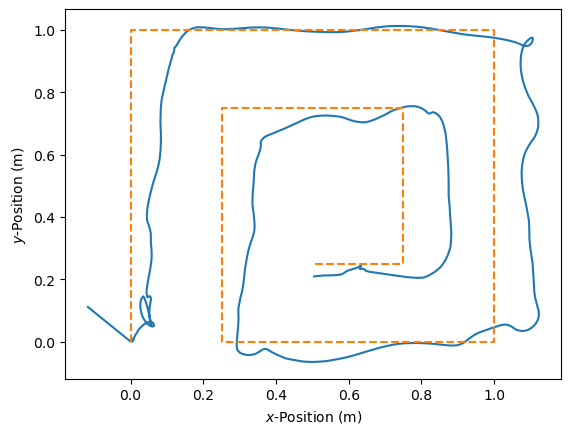

In [123]:
# flight test data
data = load_hardware_data('flight-test-data\cc_co_square_search.json', only_in_flight=False)

# state estimates from custom observer
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']

with open('preflight_data.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))

data = data[1]

x_lim = float(data[1])
y_lim = float(data[2])

expected_x = np.block([np.zeros(10),
                       np.linspace(0, x_lim, 10),
                       np.ones(10),
                       np.flip(np.linspace(0.25 * x_lim, x_lim, 10)),
                       0.25 * x_lim * np.ones(10),
                       np.linspace(0.25 * x_lim, 0.75 * x_lim, 10),
                       0.75 * x_lim * np.ones(10),
                       np.flip(np.linspace(0.5 * x_lim, 0.75 * x_lim, 10))])
expected_y = np.block([np.linspace(0, y_lim, 10),
                       np.ones(10),
                       np.flip(np.linspace(0, y_lim, 10)),
                       np.zeros(10),
                       np.linspace(0, 0.75 * y_lim, 10),
                       0.75 * y_lim * np.ones(10),
                       np.flip(np.linspace(0.25 * y_lim, 0.75 * y_lim, 10)),
                       0.25 * y_lim * np.ones(10)])

plt.plot(o_x, o_y)
plt.plot(expected_x, expected_y, '--')
plt.xlabel('$x$-Position (m)')
plt.ylabel('$y$-Position (m)')
plt.savefig('graphs\\results.png')